<a href="https://colab.research.google.com/github/himanshu230998/CS504-project/blob/main/Non_Chaotic_system_double_pendulum_return_seq_true_sequence_length(200)_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pickle
from itertools import *

import csv

import matplotlib.animation as animation
import random
import matplotlib.patches as mpatches
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score
import pandas as pd
import tensorflow as tf


from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 2.0  # mass of pendulum 2 in kg

# derivs(state,t) returns array of 4 number [Z1, Z1_dot, Z2, Z2_dot]
def derivs(state, t):
    
    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_) #del1=L1*(M1+M2*sin(del)*sin(del))
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

 
dt = 0.01
t = np.arange(0.0, 100 , dt)       #len(t)=9999
arr=[]
time=[]
state = np.radians([5, 0, 4, 0])
y = integrate.odeint(derivs, state, t)   #len(y)=9999
x1 = 1 * sin(y[:, 0])
y1 = 1 * cos(y[:, 0])
x2 = 1 * sin(y[:, 2]) + x1
y2 = 1 * cos(y[:, 2]) + y1
for i in range(len(x1)):
    # all=[x1[i],y1[i],x2[i],y2[i]]
    arr.append(np.array([x1[i],y1[i],x2[i],y2[i]]))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dt = 0.01
t = np.arange(0.0, 100 , dt)       #len(t)=9999
arr=[]
time=[]
state = np.radians([5, 0, 4, 0])
y = integrate.odeint(derivs, state, t)  
z1 = y[:,0]
z1_dot = y[:,1]
z2 = y[:,2]
z2_dot = y[:,3]

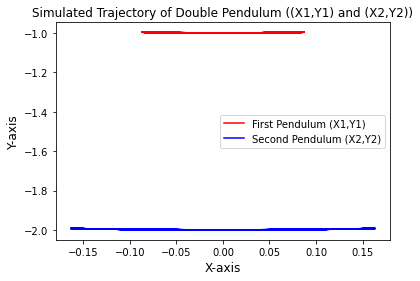

In [ ]:
plt.figure()
plt.title('Simulated Trajectory of Double Pendulum ((X1,Y1) and (X2,Y2))')
plt.xlabel('X-axis', fontsize=12)
plt.ylabel('Y-axis', fontsize=12)
plt.plot(L1*sin(z1), -L1*cos(z1),label='First Pendulum (X1,Y1)' ,color="RED")
plt.plot(L2*sin(z2)+L1*sin(z1), -L2*cos(z2)-L2*cos(z1),label='Second Pendulum (X2,Y2)' ,color="BLUE")
plt.legend()
# plt.plot(z2_dot+sin(data[:,3][8100:10000]),-cos(data[:,1][8100:10000])-cos(data[:,3][8100:10000]),color="blue")

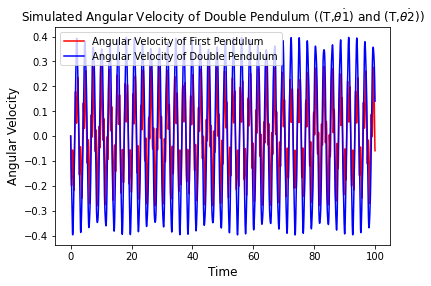

In [ ]:
plt.figure()
plt.title('Simulated Angular Velocity of Double Pendulum ((T,$\\dot{\\theta1}$) and (T,$\\dot{\\theta2}$))')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity', fontsize=12)
plt.plot(t,z1_dot,label='Angular Velocity of First Pendulum' ,color="RED")
plt.plot(t,z2_dot+z1_dot,label='Angular Velocity of Double Pendulum' ,color="blue")
plt.legend()

In [ ]:
import csv
with open('/content/drive/MyDrive/CS504 project/non-chaotic.csv', 'w', newline='') as file:
    fieldnames = ['Time', 'Z1','Z1_dot','Z2','Z2_dot']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writerow({'Time': "Time", 'Z1':"Z1",'Z1_dot': "Z1_dot",'Z2':"Z2",'Z2_dot':"Z2_dot"})
    for i in range(0,len(t)):
        writer.writerow({'Time': t[i], 'Z1':z1[i],'Z1_dot': z1_dot[i],'Z2':z2[i],'Z2_dot':z2_dot[i]})

##Data process

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS504 project/non-chaotic.csv')

In [ ]:
df

,Time,Z1,Z1_dot,Z2,Z2_dot
0,0.00,0.087266,0.000000,0.069813,0.000000
1,0.01,0.087207,-0.011939,0.069839,0.005100
2,0.02,0.087028,-0.023833,0.069915,0.010151
3,0.03,0.086730,-0.035638,0.070041,0.015102
4,0.04,0.086316,-0.047310,0.070217,0.019906
...,...,...,...,...,...
9995,99.95,0.067939,-0.045321,0.078829,0.218224
9996,99.96,0.067464,-0.049553,0.080994,0.214632
9997,99.97,0.066950,-0.053218,0.083119,0.210264
9998,99.98,0.066402,-0.056315,0.085196,0.205122


In [ ]:
df_input=df[['Time', 'Z1','Z1_dot','Z2','Z2_dot']]
df_input

,Time,Z1,Z1_dot,Z2,Z2_dot
0,0.00,0.087266,0.000000,0.069813,0.000000
1,0.01,0.087207,-0.011939,0.069839,0.005100
2,0.02,0.087028,-0.023833,0.069915,0.010151
3,0.03,0.086730,-0.035638,0.070041,0.015102
4,0.04,0.086316,-0.047310,0.070217,0.019906
...,...,...,...,...,...
9995,99.95,0.067939,-0.045321,0.078829,0.218224
9996,99.96,0.067464,-0.049553,0.080994,0.214632
9997,99.97,0.066950,-0.053218,0.083119,0.210264
9998,99.98,0.066402,-0.056315,0.085196,0.205122


In [ ]:
with open('/content/drive/MyDrive/CS504 project/non-chaotic.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    data = np.array(list(reader)).astype(float)
print(headers)
print(data.shape)
print(data)

['Time', 'Z1', 'Z1_dot', 'Z2', 'Z2_dot']
(10000, 5)
[[ 0.00000000e+00  8.72664626e-02  0.00000000e+00  6.98131701e-02
   0.00000000e+00]
 [ 1.00000000e-02  8.72067498e-02 -1.19388583e-02  6.98386911e-02
   5.10008634e-03]
 [ 2.00000000e-02  8.70278400e-02 -2.38330588e-02  6.99150004e-02
   1.01506262e-02]
 ...
 [ 9.99700000e+01  6.69497430e-02 -5.32179379e-02  8.31187649e-02
   2.10263595e-01]
 [ 9.99800000e+01  6.64016049e-02 -5.63150639e-02  8.51963331e-02
   2.05121596e-01]
 [ 9.99900000e+01  6.58253304e-02 -5.88457843e-02  8.72186400e-02
   1.99212784e-01]]


In [ ]:
data[:,0][8001:10001]

array([80.01, 80.02, 80.03, ..., 99.97, 99.98, 99.99])

In [ ]:
data[:,1][8001:10001]

array([-0.0510686 , -0.05070956, -0.05039217, ...,  0.06694974,
        0.0664016 ,  0.06582533])

In [ ]:
df_input.describe()

,Time,Z1,Z1_dot,Z2,Z2_dot
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49.995000,-0.000068,-0.000217,-0.000136,0.000184
std,28.868957,0.052113,0.142378,0.063772,0.174302
min,0.000000,-0.087253,-0.280214,-0.107167,-0.340747
25%,24.997500,-0.049670,-0.106137,-0.061014,-0.128713
50%,49.995000,-0.000187,-0.000674,-0.000079,0.001203
75%,74.992500,0.049498,0.105672,0.060841,0.128817
max,99.990000,0.087266,0.280207,0.107182,0.340724


In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [ ]:
data_scaled

array([[0.00000000e+00, 1.00000000e+00, 5.00006394e-01, 8.25663729e-01,
        5.00016868e-01],
       [1.00010001e-04, 9.99657844e-01, 4.78703033e-01, 8.25782792e-01,
        5.07500795e-01],
       [2.00020002e-04, 9.98632686e-01, 4.57479359e-01, 8.26138798e-01,
        5.14912018e-01],
       ...,
       [9.99799980e-01, 8.83584646e-01, 4.05045813e-01, 8.87738322e-01,
        8.08560170e-01],
       [9.99899990e-01, 8.80443800e-01, 3.99519389e-01, 8.97430802e-01,
        8.01014739e-01],
       [1.00000000e+00, 8.77141731e-01, 3.95003643e-01, 9.06865470e-01,
        7.92344079e-01]])

In [ ]:
features=data_scaled
target=data_scaled

In [ ]:
x_train=features[0:8000]
y_train=target[0:8000]
x_test=features[8000:10000]
y_test=target[8000:10000]

In [ ]:
win_length=200
batch_size=1
num_features=5
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
X=np.array(([train_generator[0][0][0,:]]))
Y1=np.array(np.vstack((train_generator[0][1][:,0])))
Y2=np.array(np.vstack((train_generator[0][1][:,1])))
Y3=np.array(np.vstack((train_generator[0][1][:,2])))
Y4=np.array(np.vstack((train_generator[0][1][:,3])))
Y5=np.array(np.vstack((train_generator[0][1][:,4])))

for i in range(1,7800):
    X=np.vstack((X,[train_generator[i][0][0,:]]))
    Y1=np.vstack((Y1,train_generator[i][1][:,0]))
    Y2=np.vstack((Y2,train_generator[i][1][:,1]))
    Y3=np.vstack((Y3,train_generator[i][1][:,2]))
    Y4=np.vstack((Y4,train_generator[i][1][:,3]))
    Y5=np.vstack((Y5,train_generator[i][1][:,4]))

In [ ]:
win_length=200
batch_size=1
num_features=5
title_input = keras.Input(shape= (win_length, num_features), name="title_input") 
title_features = layers.Dense(5)(title_input)

LSTM1 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM2 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM3 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM4 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM5 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)

LSTM6 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM1)
LSTM7 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM2)
LSTM8 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM3)
LSTM9 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM4)
LSTM10 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM5)

out1=layers.Dense(1,name="out1")(LSTM6)
out2=layers.Dense(1,name="out2")(LSTM7)
out3=layers.Dense(1,name="out3")(LSTM8)
out4=layers.Dense(1,name="out4")(LSTM9)
out5=layers.Dense(1,name="out5")(LSTM10)

model = keras.Model(
    inputs=[title_input],
    outputs=[out1, out2,out3,out4,out5],
)

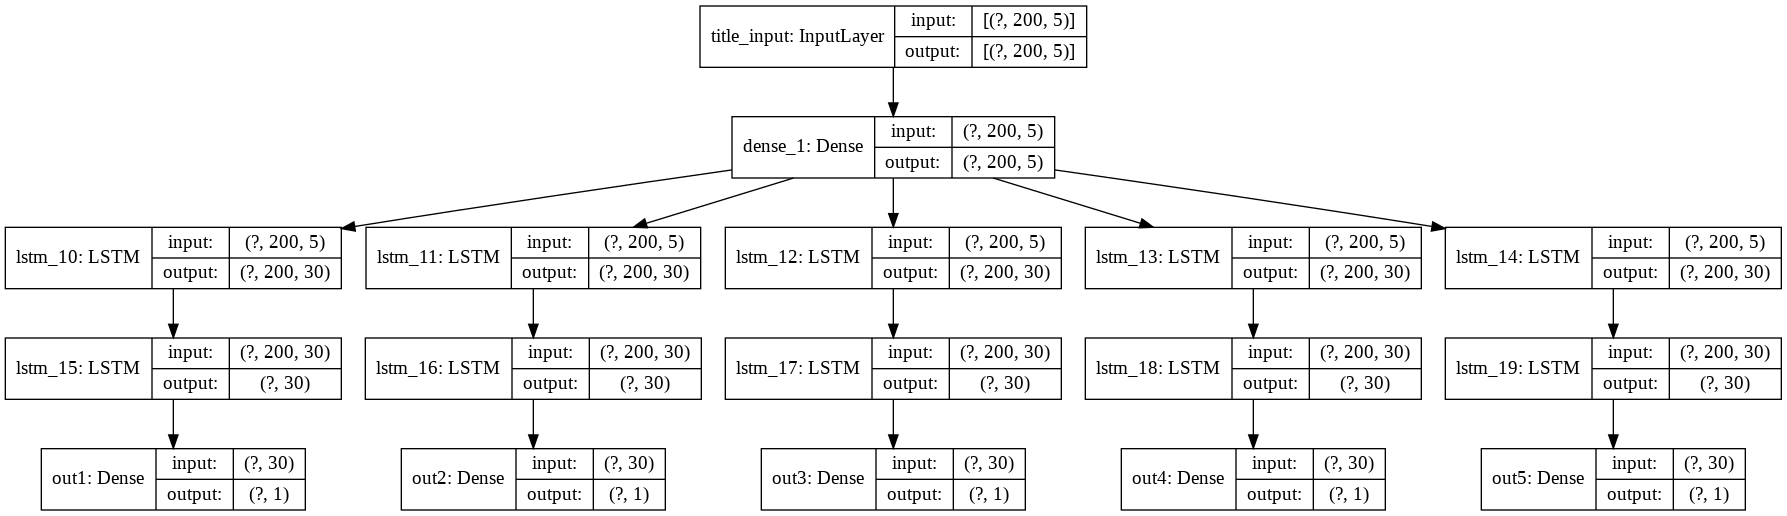

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(    {"title_input": X},
    {"out1": Y1, "out2": Y2, "out3": Y3, "out4": Y4, "out5": Y5,}, 
    epochs=30, validation_batch_size=0.1,
    shuffle=False)

Epoch 1/30
244/244 [==============================] - 18s 74ms/step - loss: 0.0644 - out1_loss: 0.0022 - out2_loss: 0.0125 - out3_loss: 0.0133 - out4_loss: 0.0181 - out5_loss: 0.0183 - out1_mean_absolute_error: 0.0314 - out2_mean_absolute_error: 0.0633 - out3_mean_absolute_error: 0.0649 - out4_mean_absolute_error: 0.0734 - out5_mean_absolute_error: 0.0859
Epoch 2/30
244/244 [==============================] - 18s 73ms/step - loss: 0.0243 - out1_loss: 0.0062 - out2_loss: 0.0012 - out3_loss: 0.0040 - out4_loss: 0.0024 - out5_loss: 0.0105 - out1_mean_absolute_error: 0.0336 - out2_mean_absolute_error: 0.0278 - out3_mean_absolute_error: 0.0310 - out4_mean_absolute_error: 0.0325 - out5_mean_absolute_error: 0.0485
Epoch 3/30
244/244 [==============================] - 18s 73ms/step - loss: 0.0212 - out1_loss: 0.0078 - out2_loss: 0.0011 - out3_loss: 0.0020 - out4_loss: 0.0014 - out5_loss: 0.0088 - out1_mean_absolute_error: 0.0404 - out2_mean_absolute_error: 0.0264 - out3_mean_absolute_error: 0.0

In [ ]:
model.evaluate_generator(test_generator, verbose=2)  
o1,o2,o3,o4,o5=model.predict_generator(test_generator)

1800/1800 - 53s - loss: 0.6498 - out1_loss: 0.1623 - out2_loss: 0.1212 - out3_loss: 0.1233 - out4_loss: 0.1190 - out5_loss: 0.1240 - out1_mean_absolute_error: 0.3086 - out2_mean_absolute_error: 0.2494 - out3_mean_absolute_error: 0.2693 - out4_mean_absolute_error: 0.2466 - out5_mean_absolute_error: 0.2722


In [ ]:
testX=np.array(([test_generator[0][0][0,:]]))
testY1=np.array(np.vstack((test_generator[0][1][:,0])))
testY2=np.array(np.vstack((test_generator[0][1][:,1])))
testY3=np.array(np.vstack((test_generator[0][1][:,2])))
testY4=np.array(np.vstack((test_generator[0][1][:,3])))
testY5=np.array(np.vstack((test_generator[0][1][:,4])))

for i in range(1,1799):
    testX=np.vstack((X,[test_generator[i][0][0,:]]))
    testY1=np.vstack((Y1,test_generator[i][1][:,0]))
    testY2=np.vstack((Y2,test_generator[i][1][:,1]))
    testY3=np.vstack((Y3,test_generator[i][1][:,2]))
    testY4=np.vstack((Y4,test_generator[i][1][:,3]))
    testY5=np.vstack((Y5,test_generator[i][1][:,4]))

In [ ]:
df_pred=pd.concat([pd.DataFrame(o1), pd.DataFrame(o2),pd.DataFrame(o3),pd.DataFrame(o4),pd.DataFrame(o5)],axis=1)

In [ ]:
df_pred

,0,0,0,0,0
0,0.811297,0.306851,0.059607,0.410434,0.367673
1,0.811273,0.292569,0.070989,0.405859,0.360286
2,0.811239,0.278649,0.083360,0.401060,0.352251
3,0.811196,0.265130,0.096671,0.396022,0.343627
4,0.811145,0.252051,0.110870,0.390733,0.334477
...,...,...,...,...,...
1795,0.884730,0.866848,0.409700,0.850547,0.783205
1796,0.884709,0.864112,0.402018,0.860074,0.778140
1797,0.884697,0.861228,0.395371,0.869362,0.771986
1798,0.884691,0.858216,0.389758,0.878389,0.764738


In [ ]:
rev_trans=scaler.inverse_transform(df_pred)
rev_trans

array([[ 8.1121552e+01, -3.3701371e-02, -2.4680933e-01, -1.9190652e-02,
        -9.0188809e-02],
       [ 8.1119141e+01, -3.6193859e-02, -2.4043025e-01, -2.0171376e-02,
        -9.5222503e-02],
       [ 8.1115761e+01, -3.8623191e-02, -2.3349765e-01, -2.1200024e-02,
        -1.0069797e-01],
       ...,
       [ 8.8460838e+01,  6.3048139e-02, -5.8639631e-02,  7.9179779e-02,
         1.8533905e-01],
       [ 8.8460220e+01,  6.2522411e-02, -6.1785508e-02,  8.1114754e-02,
         1.8039991e-01],
       [ 8.8460091e+01,  6.1977152e-02, -6.4357094e-02,  8.2989782e-02,
         1.7471659e-01]], dtype=float32)

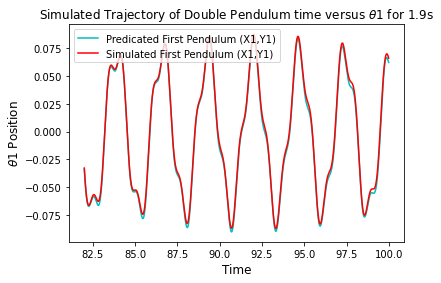

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('$\\theta1$ Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum time versus $\\theta1$ for 1.9s')
plt.plot(data[:,0][8200:10000], rev_trans[:,1],label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(data[:,0][8200:10000],data[:,1][8200:10000],label='Simulated First Pendulum (X1,Y1)' ,color="red")
plt.legend()

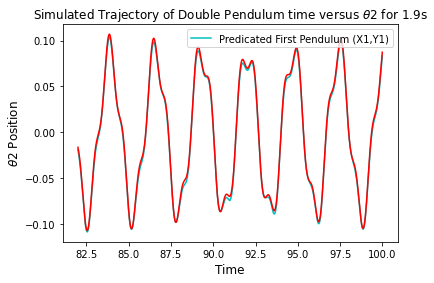

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('$\\theta2$ Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum time versus $\\theta2$ for 1.9s')
plt.plot(data[:,0][8200:10000], rev_trans[:,3],label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(data[:,0][8200:10000],data[:,3][8200:10000],color="red")
plt.legend()

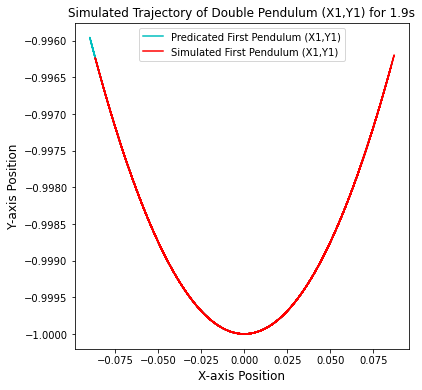

In [ ]:
plt.figure(figsize=(6,6))
plt.xlabel('X-axis Position', fontsize=12)
plt.ylabel('Y-axis Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum (X1,Y1) for 1.9s')
plt.plot(L1*sin(rev_trans[:,1]), -L1*cos(rev_trans[:,1]),label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(L1*sin(data[:,1][8200:10000]), -L1*cos(data[:,1][8200:10000]),label='Simulated First Pendulum (X1,Y1)' ,color="RED")
plt.legend()

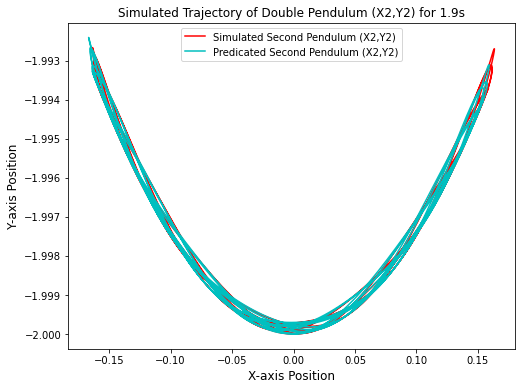

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('X-axis Position', fontsize=12)
plt.ylabel('Y-axis Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum (X2,Y2) for 1.9s')
plt.plot(L2*sin(data[:,3][8200:10000])+L1*sin(data[:,1][8200:10000]), -L2*cos(data[:,3][8200:10000])-L2*cos(data[:,1][8200:10000]),label='Simulated Second Pendulum (X2,Y2)' ,color="RED")
plt.plot(L2*sin(rev_trans[:,3])+L1*sin(rev_trans[:,1]), -L2*cos(rev_trans[:,3])-L2*cos(rev_trans[:,1]),label='Predicated Second Pendulum (X2,Y2)' ,color="c")
plt.legend()

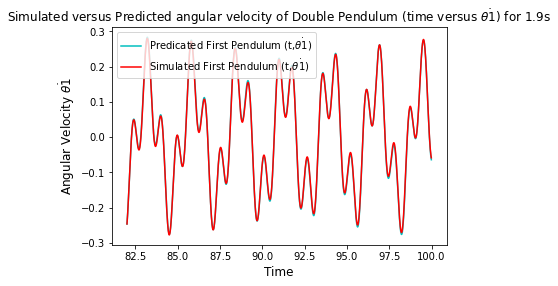

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity $\\dot{\\theta1}$', fontsize=12)
plt.title('Simulated versus Predicted angular velocity of Double Pendulum (time versus $\\dot{\\theta1}$) for 1.9s')
plt.plot(data[:,0][8200:10000], rev_trans[:,2],label='Predicated First Pendulum (t,$\\dot{\\theta1}$)' ,color="c")
plt.plot(data[:,0][8200:10000],data[:,2][8200:10000],label='Simulated First Pendulum (t,$\\dot{\\theta1}$)' ,color="red")
plt.legend()

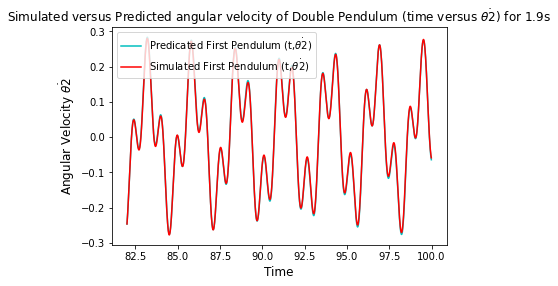

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity $\\dot{\\theta2}$', fontsize=12)
plt.title('Simulated versus Predicted angular velocity of Double Pendulum (time versus $\\dot{\\theta2}$) for 1.9s')
plt.plot(data[:,0][8200:10000], rev_trans[:,2],label='Predicated First Pendulum (t,$\\dot{\\theta2}$)' ,color="c")
plt.plot(data[:,0][8200:10000],data[:,2][8200:10000],label='Simulated First Pendulum (t,$\\dot{\\theta2}$)' ,color="red")
plt.legend()